In [68]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing
import importlib
import gomokutrainer
import onnx
import keras2onnx
import matplotlib.pyplot as plt
from os import path
from datetime import datetime


data_train_x_board (49229) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_train_x_turn (49229) 
 [[-5]
 [-5]
 [-5]
 ...
 [-7]
 [-7]
 [-7]]
data_train_y (49229) 
 [[-1.]
 [-1.]
 [-1.]
 ...
 [ 1.]
 [ 1.]
 [ 1.]]
data_validation_x_board (2592) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_validation_x_turn (2592) 
 [[-5]
 [-5]
 [-5]
 ...
 [-7]
 [-7]
 [-7]]
data_validation_y (2592) 
 [[-1.]
 [-1.]
 [-1.]
 ...
 [ 1.]
 [ 1.]
 [ 1.]]
classes (70574)) 
 0        5.0
1        5.0
2        6.0
3        7.0
4        7.0
        ... 
70569    8.0
70570    4.0
70571    5.0
70572    6.0
70573    6.0
Name: 227, Length: 70574, dtype: float64


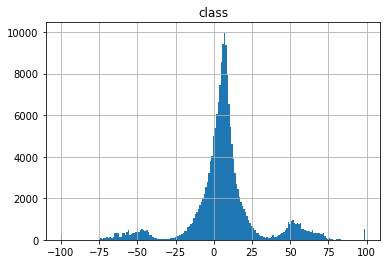

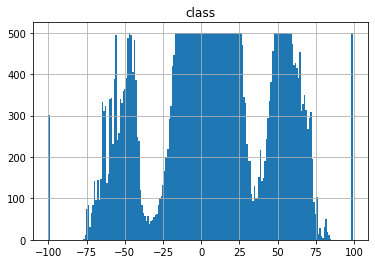

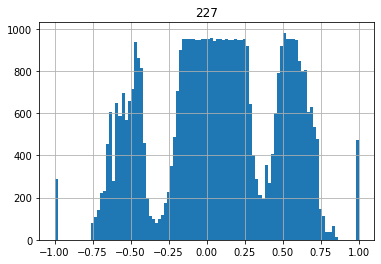

In [79]:
data_raw = pd.concat([
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\v2_2021-05-05_09-26-20.csv", header=None, sep=';', decimal=","),
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\v2_I30000_MEC1000_05-06_10-36-25.csv", header=None, sep=';', decimal=",")
], ignore_index = True)
input_slice = range(225)
##Reverse first player evaluations
#print("before \n", data_raw[lambda x: x[450] == 1])
data_raw.loc[lambda x: x[225] == 1,227] = data_raw.loc[lambda x: x[225] == 1,227].apply(lambda x: x*-1)
#data_raw.loc[lambda x: x[225] == 1,input_slice] = data_raw.loc[lambda x: x[225] == 1,input_slice].apply(lambda x: x*-1)
#print("after \n", data_raw[lambda x: x[450] == 1])
data_raw["class"] = data_raw[227] // 0.01

data_raw.hist(column="class", bins=200)

max_class_count = 500

data_raw = data_raw.groupby("class").apply(lambda x: x.sample(max_class_count if len(x) > max_class_count else len(x) )).reset_index(drop=True)

data_raw.hist(column="class", bins=200)

data_train = data_raw[data_raw.index % 20 != 0].reset_index(drop = True)
data_validation = data_raw[data_raw.index % 20 == 0].reset_index(drop = True)

data_train_x_board = data_train[input_slice].to_numpy()
data_train_x_turn = data_train[225].to_numpy().reshape((-1,1)) * -2 - 3
data_validation_x_board = data_validation[input_slice].to_numpy()
data_validation_x_turn = data_validation[225].to_numpy().reshape((-1,1)) * -2 - 3

data_train_y = data_train[[227]].to_numpy()
data_validation_y = data_validation[[227]].to_numpy()

data_train.hist(column=227, bins=100)



print(f"data_train_x_board ({len(data_train_x_board)}) \n", data_train_x_board)
print(f"data_train_x_turn ({len(data_train_x_turn)}) \n", data_train_x_turn)
print(f"data_train_y ({len(data_train_y)}) \n", data_train_y)
print(f"data_validation_x_board ({len(data_validation_x_board)}) \n", data_validation_x_board)
print(f"data_validation_x_turn ({len(data_validation_x_turn)}) \n", data_validation_x_turn)
print(f"data_validation_y ({len(data_validation_y)}) \n", data_validation_y)
print(f"classes ({len(classes)})) \n", classes)

#print(data_train_x[100])
#print(data_train_y[100])

In [103]:
#importlib.reload(gomokutrainer)
#from gomokutrainer import create_model
#model = create_model()
input_shape = (15,15,1)
input_len = input_shape[0] * input_shape[1] * input_shape[2]
"""
model = keras.Sequential(
    [
      keras.Input(shape=input_len, name="input"),

      layers.Reshape(input_shape),

      layers.Conv2D(32, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(64, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(128, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Flatten(),

      layers.Dropout(0.5),

      layers.Dense(128,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(64,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(32,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(1, activation='tanh', name="output")
    ]
  )
  """
"""
model = keras.Sequential(
  [
    keras.Input(shape=input_len, name="input"),

    layers.Reshape(input_shape),

    layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='lecun_normal', activation='selu'),

    layers.Flatten(),

    layers.Dropout(0.5),

    layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'),

    layers.Dense(1, activation='tanh', name="output")
  ]
)
"""
"""
model = keras.Sequential(
    [
      keras.Input(shape=input_len, name="input"),

      layers.Reshape(input_shape),

      layers.Conv2D(32, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Conv2D(64, kernel_size=(3, 3),
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Flatten(),

      layers.Dropout(0.5),

      layers.Dense(64,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(32,
        kernel_initializer=keras.initializers.HeNormal()),
      layers.LeakyReLU(alpha=0.2),

      layers.Dense(1, activation='tanh', name="output")
    ]
  )"""
inputA = keras.Input(shape=input_len)
inputB = keras.Input(shape=1)
a = layers.Reshape(input_shape)(inputA)

a = layers.Conv2D(32, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

a = layers.Conv2D(64, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

a = layers.Flatten()(a)

a =  layers.Dropout(0.5)(a)

a = layers.Dense(64, kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

#b = layers.Dense(2, kernel_initializer=keras.initializers.HeNormal())(inputB)
#b = layers.LeakyReLU(alpha=0.2)(b)

#a = layers.Concatenate()([a, b])
a = layers.Concatenate()([a, inputB])

a = layers.Dense(32, kernel_initializer=keras.initializers.HeNormal())(a)
a = layers.LeakyReLU(alpha=0.2)(a)

a = layers.Dense(1, activation='tanh', name="output")(a)

model = keras.Model(inputs=[inputA,inputB], outputs=a)

model.compile(tf.optimizers.RMSprop(), loss='mse')
model.summary()

Model: "functional_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 225)]        0                                            
__________________________________________________________________________________________________
reshape_25 (Reshape)            (None, 15, 15, 1)    0           input_51[0][0]                   
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 14, 14, 32)   160         reshape_25[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_110 (LeakyReLU)     (None, 14, 14, 32)   0           conv2d_50[0][0]                  
______________________________________________________________________________________

In [104]:
history = model.fit([data_train_x_board,data_train_x_turn], data_train_y, epochs=50, 
    validation_data=([data_validation_x_board,data_validation_x_turn], data_validation_y))

#predictions = model.predict(data_validation_x)

Epoch 1/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0619 - val_loss: 0.0276
Epoch 2/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0303 - val_loss: 0.0221
Epoch 3/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0242 - val_loss: 0.0173
Epoch 4/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0210 - val_loss: 0.0188
Epoch 5/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0194 - val_loss: 0.0154
Epoch 6/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0180 - val_loss: 0.0150
Epoch 7/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0170 - val_loss: 0.0145
Epoch 8/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0161 - val_loss: 0.0134
Epoch 9/50
1539/1539 [==============================] - 22s 14ms/step - loss: 0.0155 - val_loss: 0.0143
Epoch 10/50
1539/1539 [==============================] - 22s 14m

KeyboardInterrupt: 

minimal validation loss = 0.008933965116739273


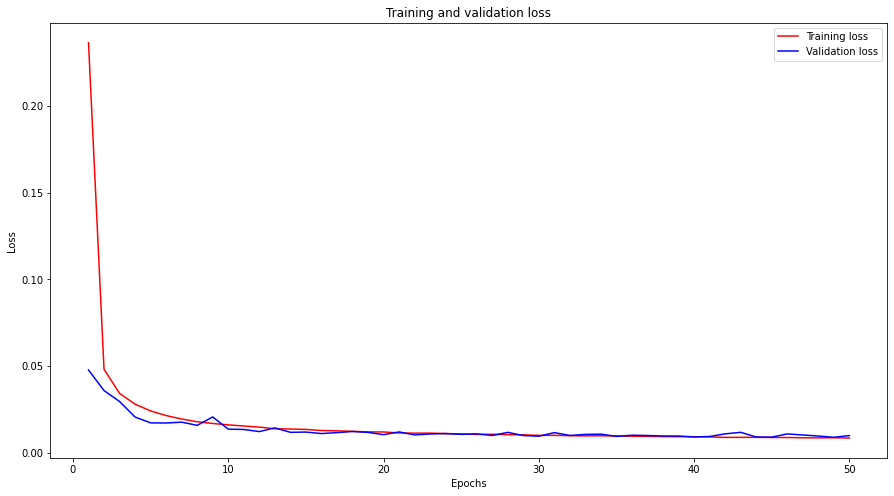

In [98]:

history.history.keys()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'minimal validation loss = {min(val_loss)}' )

In [73]:
output_path = path.join("C:\\","Projects","TrainDatasetGenerator","TrainedModels", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
model.save(path.join(output_path,"keras-model"))
onnx_model = keras2onnx.convert_keras(model, "model.onnx")
onnx.save_model(onnx_model, path.join(output_path, "model.onnx"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Projects\TrainDatasetGenerator\TrainedModels\2021-05-17_22-27-20\keras-model\assets
tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 31 -> 18
The maximum opset needed by this model is only 11.
